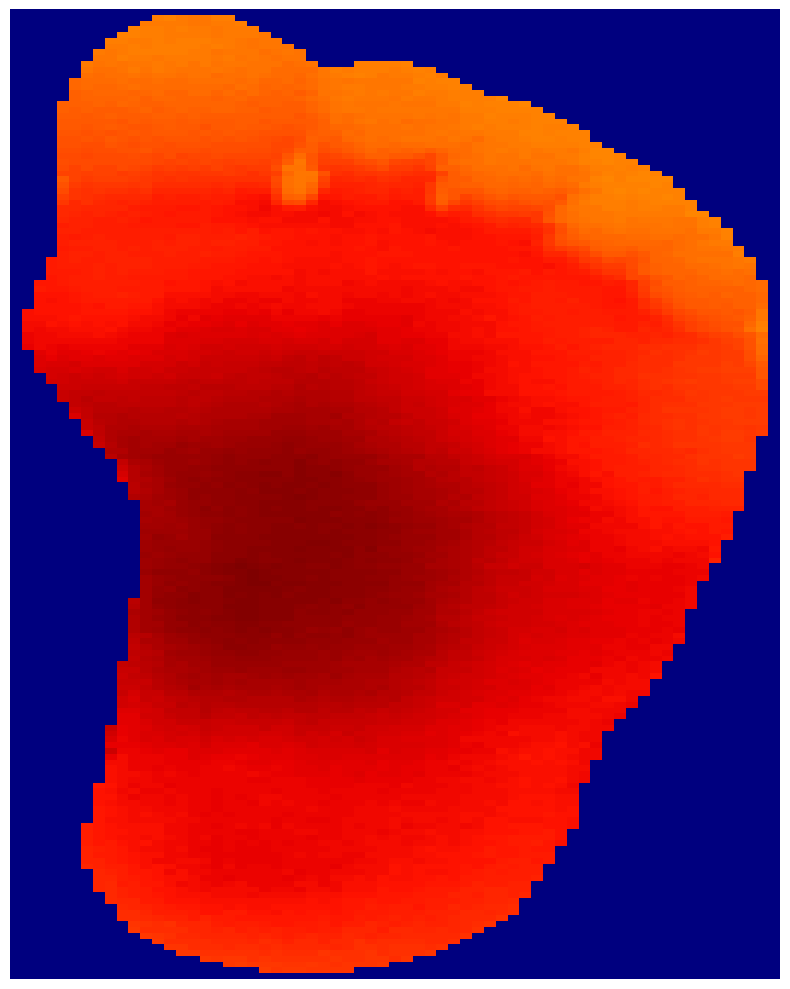

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv('/content/CG001_M_L.csv', header=None)
# Convert the data to a numpy array
temperature_data = data.to_numpy()

# Normalize the temperature data for color mapping
normalized_data = (temperature_data - np.min(temperature_data)) / (np.max(temperature_data) - np.min(temperature_data))
# Generate the image
plt.figure(figsize=(8, 10))  # You can adjust the size as needed
plt.imshow(normalized_data, cmap='jet', aspect='auto')
plt.axis('off')  # Hide the axes
plt.tight_layout()  # Adjust layout
plt.show()
# Save the generated image as a PNG file
plt.imsave('generated_image_CG001.png', normalized_data, cmap='jet')


preprocessing step

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

# Load the image generated from the previous code
image = plt.imread('/content/generated_image_CG001.png')

# Step 1: Min-max normalization (mapping values between 0 and 255)
# "To map values between 0 and 255, min-max normalization was used"
if image.dtype != np.uint8:
    normalized_img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
else:
    normalized_img = image.copy()

# Step 2: Apply contrast enhancement
# "we applied normalization and contrast enhancement to the thermal images"
# Convert to grayscale if it's a color image
if len(normalized_img.shape) > 2:
    gray_img = cv2.cvtColor(normalized_img, cv2.COLOR_RGB2GRAY)
else:
    gray_img = normalized_img

# Step 3: Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
# "Contrast limited adaptive histogram equalization (CLAHE) was employed"
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(gray_img)

# Save the preprocessed image
cv2.imwrite('preprocessed_thermal_image_CG001.png', clahe_img)

# # Optional: Feature extraction using SIFT and SURF as mentioned in the paper
# # "This is the first work that utilizes SIFT, SURF, and BOF techniques"
# sift = cv2.SIFT_create()
# keypoints_sift = sift.detect(clahe_img, None)

# # Draw and save SIFT keypoints
# sift_img = cv2.drawKeypoints(clahe_img, keypoints_sift, None,
#                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# cv2.imwrite('sift_keypoints.png', sift_img)

# # Note: SURF implementation might require additional modules in some OpenCV versions
# try:
#     surf = cv2.xfeatures2d.SURF_create(400)
#     keypoints_surf = surf.detect(clahe_img, None)
#     surf_img = cv2.drawKeypoints(clahe_img, keypoints_surf, None,
#                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#     cv2.imwrite('surf_keypoints.png', surf_img)
# except:
#     print("SURF detector not available in this OpenCV version")


True

surf code

Number of keypoints: 48
Descriptor shape: (48, 64)


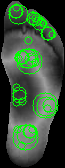

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import for Colab display

# ------------- Fixed Integral Image Function -------------
def integral_image(image):
    """Efficient integral image calculation using numpy."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

# ------------- Box Filter Function (Corrected for SURF) -------------
def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)  # Assign to x1 directly
    y1 = max(1, y - half_size)  # Assign to y1 directly
    x2 = min(integral_img.shape[0] - 1, x + half_size) # Keep within bounds
    y2 = min(integral_img.shape[1] - 1, y + half_size)  # Keep within bounds (y2 was missing)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

# ------------- Hessian Response Calculation (Corrected for SURF) -------------
def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""

    # SURF-like box filters (sizes are indicative)
    width = size
    Dxx = box_filter(integral_img, x, y, width)
    Dyy = box_filter(integral_img, x, y, width)
    Dxy = box_filter(integral_img, x, y, width) #Correct sizes later

    return (Dxx * Dyy) - (0.9 * Dxy)**2  # The 0.9 factor is important!

# ------------- Keypoint Detection with Non-Maximal Suppression -------------
def detect_keypoints(integral_img, min_hessian=700, octaves=3, octave_layers=2): #Adjust min_hessian
    """Detects SURF keypoints in the integral image."""
    keypoints = []
    for octave in range(octaves):
        for layer in range(octave_layers):
            size = 9 + (octave + layer) * 6  # Filter sizes increase with octave and layer
            step = 2**(octave) # Adjust step size for each octave

            for x in range(size//2, integral_img.shape[0] - size//2 -1, step): #Bounds check
                for y in range(size//2, integral_img.shape[1] - size//2 -1, step): #Bounds check
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:  # Basic thresholding
                        # --- Non-Maximal Suppression (Simplified) ---
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step #Use step size
                                neighbor_y = y + dy * step #Use step size

                                # Bounds Check
                                if (neighbor_x >= 0 and neighbor_x < integral_img.shape[0] and
                                    neighbor_y >= 0 and neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size) #Pass correct paramters for hessian calculation
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break
                        if is_local_max:
                             keypoints.append((x, y, size, response)) #Append keypoints

    return keypoints

# ------------- Simplified Keypoint Orientation -------------
def calculate_orientation(integral_img, keypoint, radius=6):
    """Placeholder orientation calculation."""
    # Replace with actual Haar wavelet-based calculation
    return 0.0  # Return a dummy orientation for now

# ------------- Simplified Descriptor Creation -------------
def create_descriptor(integral_img, keypoint, orientation, descriptor_size=20, subregion_size=5):
    """Placeholder descriptor creation (replace with actual implementation)."""
    return np.zeros(64)  # Return a dummy 64D descriptor

# ------------- Load Image & Compute Integral Image -------------
try:
    image = cv2.imread('/content/CG001_M_L.png', cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not loaded! Check file path.")
except Exception as e:
    print(f"Error loading image: {e}")
    raise  # Re-raise the exception

image = image.astype(np.float32)  # Prevent overflow
integral_img = integral_image(image)

# Detect keypoints and generate descriptors
keypoints = detect_keypoints(integral_img)

# Process keypoints and generate descriptors
descriptors = []
oriented_keypoints = []

for keypoint in keypoints:
    orientation = calculate_orientation(integral_img, keypoint)
    descriptor = create_descriptor(integral_img, keypoint, orientation)
    descriptors.append(descriptor)
    oriented_keypoints.append((keypoint, orientation))

descriptors = np.array(descriptors)

print("Number of keypoints:", len(oriented_keypoints))
print("Descriptor shape:", descriptors.shape)

# ------------- Visualization -------------
output_image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2BGR) # Convert to color
for keypoint, orientation in oriented_keypoints:
    x, y, size, _ = keypoint
    cv2.circle(output_image, (int(y), int(x)), int(size / 2), (0, 255, 0), 1)  # Draw circles

# Display or save the output image
cv2_imshow(output_image)  # Use cv2_imshow in Colab

add,preprocess step in code and ask to save the descriptors in a excel file

another surf code

Detected 53 keypoints
Generated 53 descriptors of shape (53, 64)
Descriptors saved to surf_descriptors_right.xlsx


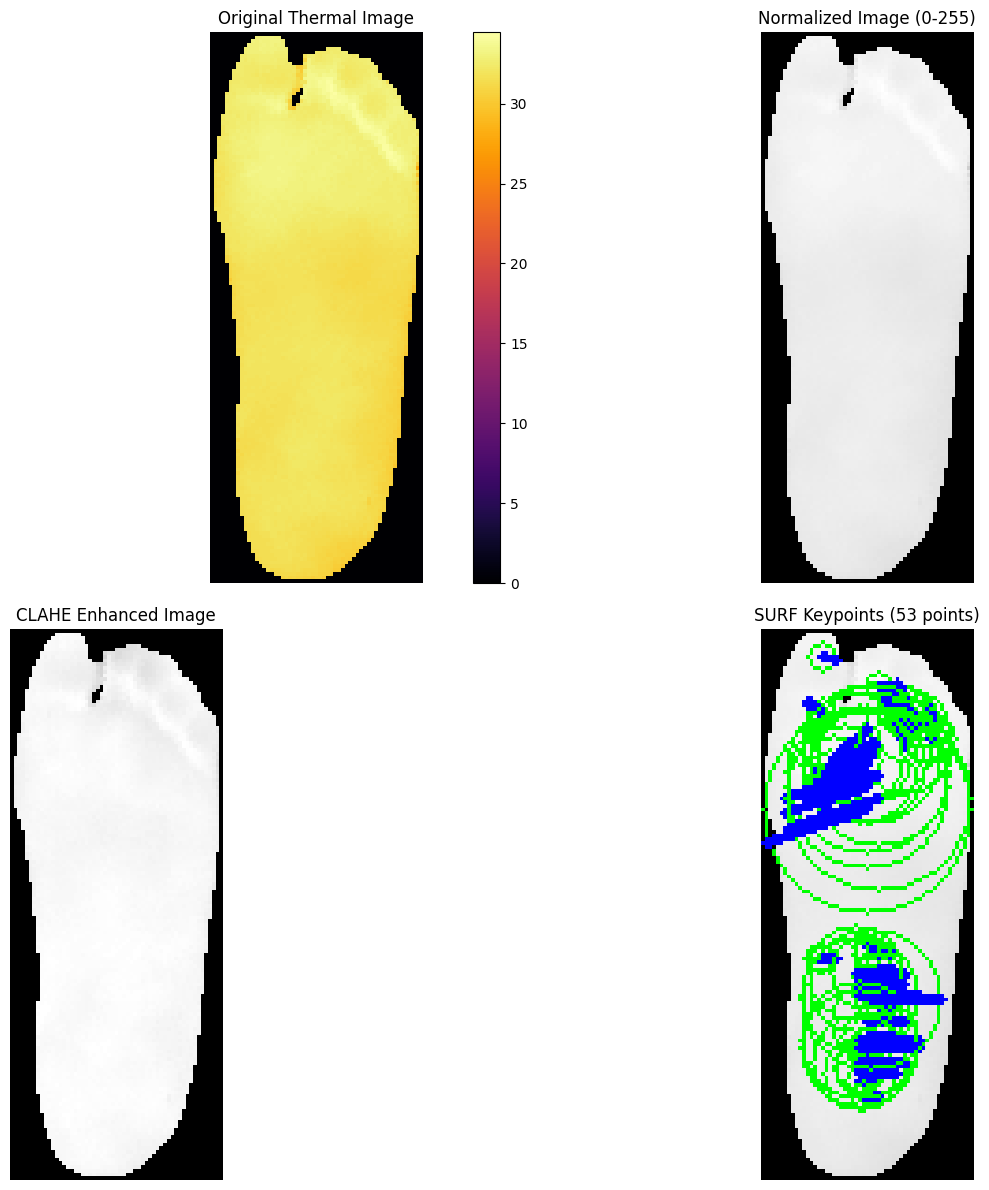

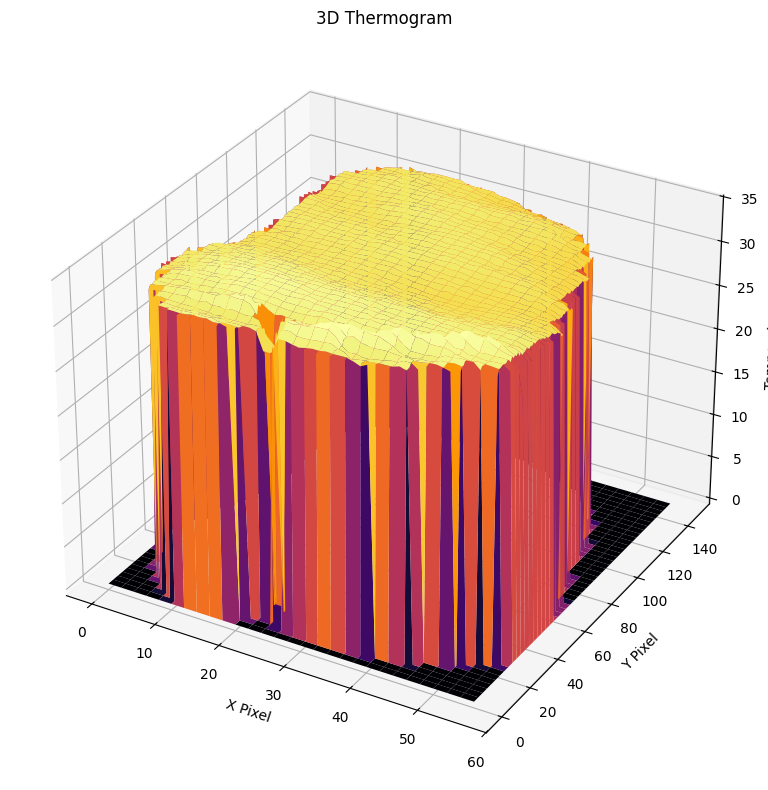

Detected 53 keypoints
Generated 53 descriptors of shape (53, 64)
Descriptors saved to surf_descriptors_right.xlsx


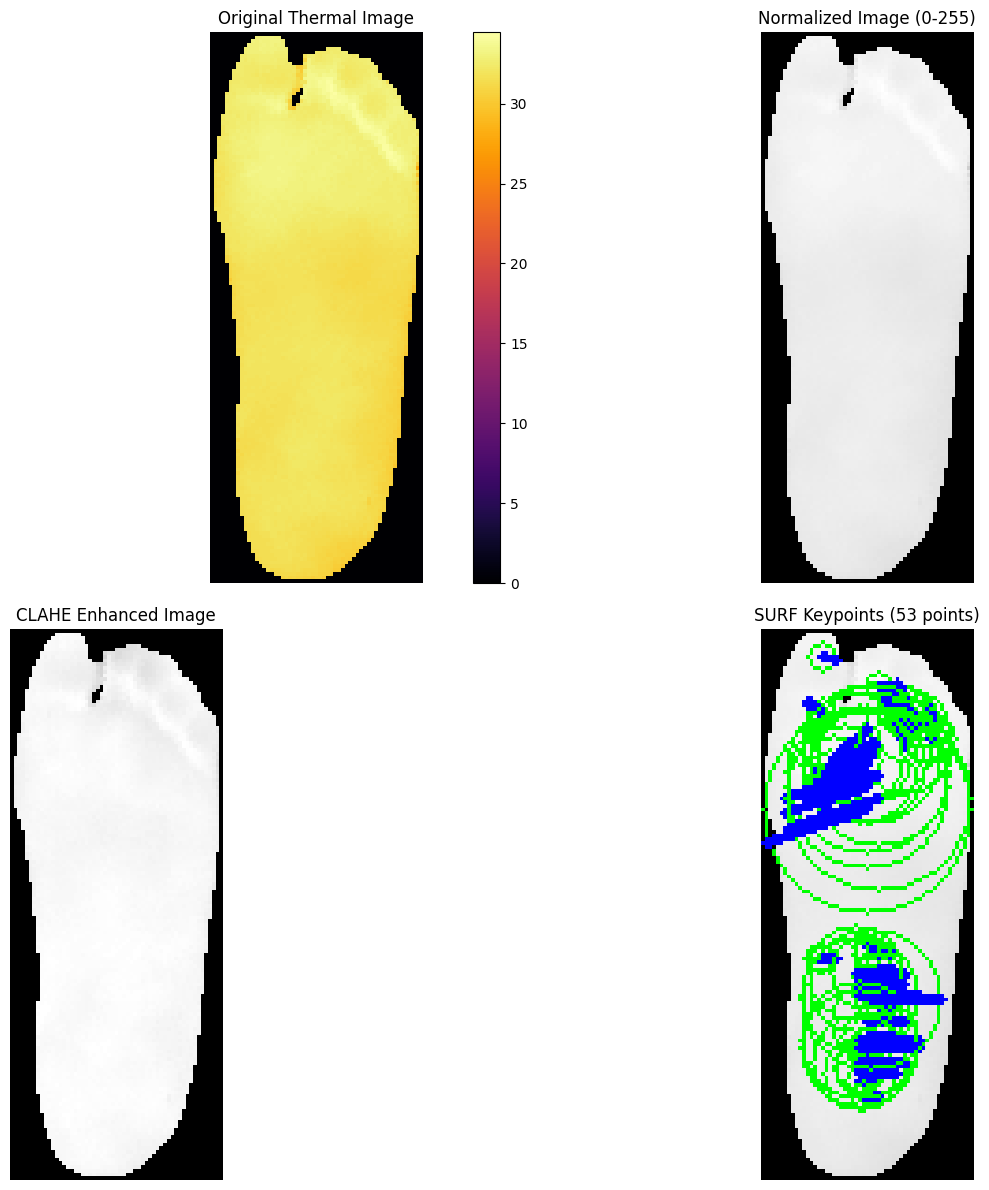

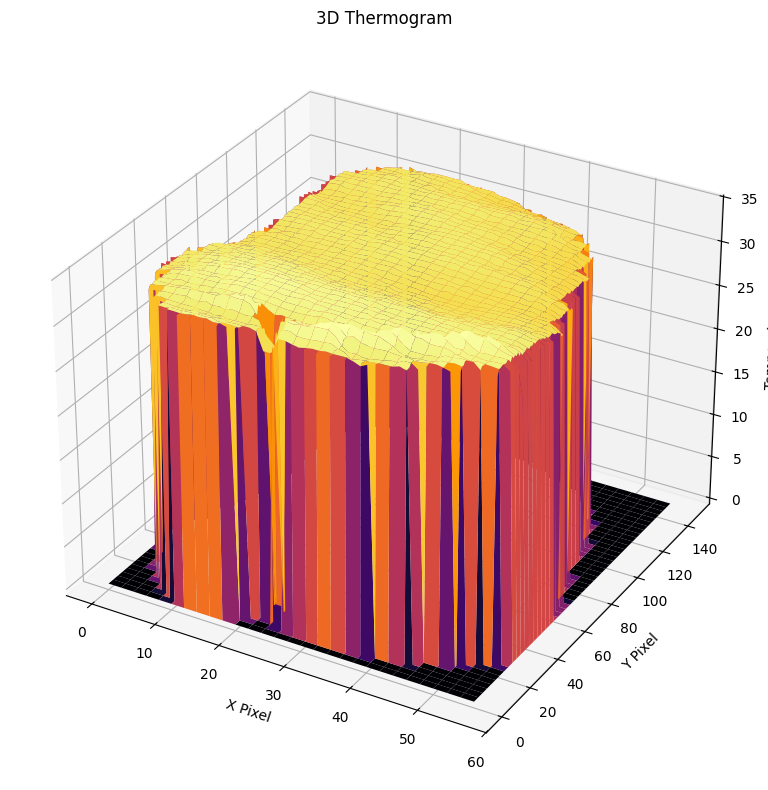

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Compute integral image for efficient box filtering
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

# Step 2: Hessian matrix determinant calculation using box filters
def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

# Step 3: Keypoint detection across scale spaces
def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

# Step 4: Calculate Haar wavelet responses
def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

# Step 5: Orientation assignment
def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation using sliding window of size π/3 (60°)
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            # Handle wrap around at 0/2π
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

# Step 6: Descriptor creation
def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor: (∑dx, ∑dy, ∑|dx|, ∑|dy|)
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

# Main SURF feature extraction function
def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# Visualization function
def visualize_keypoints(image, keypoints):
    """Visualize detected keypoints on the image."""
    vis_image = image.copy()
    if len(vis_image.shape) == 2:
        vis_image = cv2.cvtColor(vis_image, cv2.COLOR_GRAY2BGR)

    for keypoint in keypoints:
        x, y, size, _, orientation = keypoint

        # Draw circle around keypoint
        cv2.circle(vis_image, (int(y), int(x)), int(size/2), (0, 255, 0), 1)

        # Draw orientation line
        rad = np.radians(orientation)
        end_x = int(x + (size/2) * np.sin(rad))
        end_y = int(y + (size/2) * np.cos(rad))
        cv2.line(vis_image, (int(y), int(x)), (int(end_y), int(end_x)), (255, 0, 0), 2)

    return vis_image

def main():
    # Load CSV data and create thermal image
    csv_path = '/content/CSV Folder.csv'
    data = pd.read_csv(csv_path, header=None)
    temperature_data = data.to_numpy()

    # Normalize to [0, 255] for image processing
    normalized_data = ((temperature_data - np.min(temperature_data)) /
                       (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(normalized_data)

    # Extract SURF features from normalized image
    keypoints, descriptors = extract_surf_features(normalized_data, min_hessian=500)

    print(f"Generated {len(descriptors)} descriptors of shape {descriptors.shape}")

    # Visualize keypoints
    result_image = visualize_keypoints(normalized_data, keypoints)

    # Save results
    cv2.imwrite('thermal_image_right.png', normalized_data)
    cv2.imwrite('keypoints_right.png', result_image)
    cv2.imwrite('clahe_image_right.png', clahe_image)
    pd.DataFrame(descriptors).to_excel('surf_descriptors_right.xlsx', index=False)
    print("Descriptors saved to surf_descriptors_right.xlsx")

    # 2D Visualizations
    plt.figure(figsize=(18, 12))

    # Original thermal data
    plt.subplot(2, 2, 1)
    plt.imshow(temperature_data, cmap='inferno')
    plt.title('Original Thermal Image')
    plt.colorbar()
    plt.axis('off')

    # Normalized image
    plt.subplot(2, 2, 2)
    plt.imshow(normalized_data, cmap='gray')
    plt.title('Normalized Image (0-255)')
    plt.axis('off')

    # CLAHE image
    plt.subplot(2, 2, 3)
    plt.imshow(clahe_image, cmap='gray')
    plt.title('CLAHE Enhanced Image')
    plt.axis('off')

    # Keypoints
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f'SURF Keypoints ({len(keypoints)} points)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 3D Thermogram visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    X = np.arange(temperature_data.shape[1])
    Y = np.arange(temperature_data.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = temperature_data

    ax.plot_surface(X, Y, Z, cmap='inferno', edgecolor='none')
    ax.set_title('3D Thermogram')
    ax.set_xlabel('X Pixel')
    ax.set_ylabel('Y Pixel')
    ax.set_zlabel('Temperature')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


if __name__ == '__main__':
    main()


for a single file with bof technique

Extracting SURF features...
Detected 11 keypoints
Generated 11 descriptors of shape (11, 64)
Applying BOF technique...
Clustering 11 descriptors to form 11 visual words...
Generated BOF histogram with 11 bins


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Descriptors saved to surf_descriptors.xlsx
BOF histogram saved to bof_histogram.xlsx


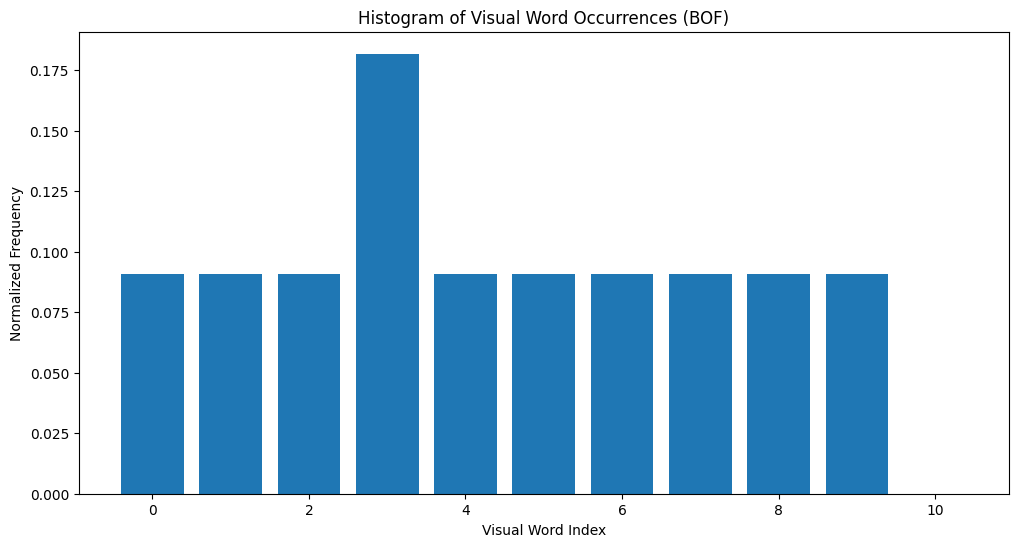

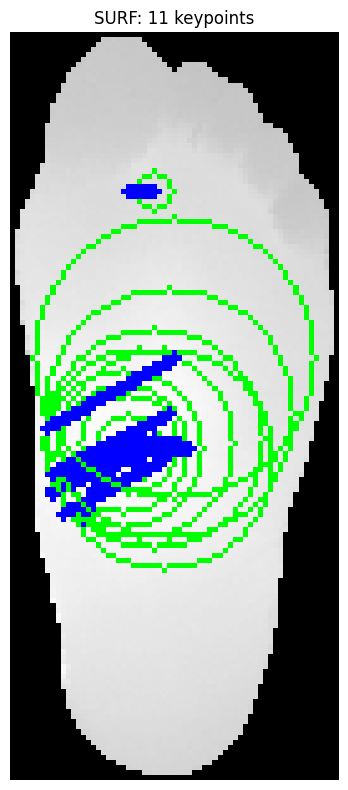

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Compute integral image for efficient box filtering
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

# Step 2: Hessian matrix determinant calculation using box filters
def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

# Step 3: Keypoint detection across scale spaces
def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

# Step 4: Calculate Haar wavelet responses
def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

# Step 5: Orientation assignment
def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation using sliding window of size π/3 (60°)
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            # Handle wrap around at 0/2π
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

# Step 6: Descriptor creation
def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor: (∑dx, ∑dy, ∑|dx|, ∑|dy|)
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

# Main SURF feature extraction function
def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# Step 7: Implement BOF technique
# Step 7: Implement BOF technique
def create_bof_histogram(descriptors, max_k=50):
    """
    Create a BOF histogram for the given descriptors with adaptive k.
    """

    # Adaptive k value
    k = min(max_k, len(descriptors))  # Corrected indentation
    if k < 10:
        print("Warning: Very few features. Consider adjusting SURF detection.")

    print(f"Clustering {len(descriptors)} descriptors to form {k} visual words...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(descriptors)

    #... (rest of the original code) ...

    # Assign each descriptor to a cluster (visual word)
    visual_words = kmeans.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(k+1), density=True)

    return histogram, kmeans

def apply_bof_to_new_image(descriptors, kmeans_model):
    """
    Apply the BOF model to new descriptors.

    Args:
        descriptors: Array of descriptors to classify.
        kmeans_model: Trained KMeans model.

    Returns:
        BOF histogram for the descriptors.
    """
    # Assign each descriptor to a cluster
    if len(descriptors) == 0:
        return np.zeros(kmeans_model.n_clusters)

    visual_words = kmeans_model.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(kmeans_model.n_clusters+1), density=True)

    return histogram

# Function to find optimal k value for BOF
def find_optimal_k(descriptors, k_values=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    """
    Find the optimal k value for BOF by checking model performance.

    Args:
        descriptors: Array of descriptors to cluster.
        k_values: List of k values to test.

    Returns:
        Results for each k value.
    """
    results = []

    for k in k_values:
        print(f"Testing k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(descriptors)

        # Calculate inertia (sum of squared distances to closest centroid)
        inertia = kmeans.inertia_

        results.append((k, inertia))
        print(f"k={k}, inertia={inertia}")

    return results

# Visualization function
def visualize_keypoints(image, keypoints):
    """Visualize detected keypoints on the image."""
    vis_image = image.copy()
    if len(vis_image.shape) == 2:
        vis_image = cv2.cvtColor(vis_image, cv2.COLOR_GRAY2BGR)

    for keypoint in keypoints:
        x, y, size, _, orientation = keypoint

        # Draw circle around keypoint
        cv2.circle(vis_image, (int(y), int(x)), int(size/2), (0, 255, 0), 1)

        # Draw orientation line
        rad = np.radians(orientation)
        end_x = int(x + (size/2) * np.sin(rad))
        end_y = int(y + (size/2) * np.cos(rad))
        cv2.line(vis_image, (int(y), int(x)), (int(end_y), int(end_x)), (255, 0, 0), 2)

    return vis_image

# Main function with BOF integration
def main():
    # Load CSV data and create thermal image
    csv_path = '/content/CG005_F_L.csv'
    data = pd.read_csv(csv_path, header=None)
    temperature_data = data.to_numpy()

    # Normalize to [0, 255] for image processing
    normalized_data = ((temperature_data - np.min(temperature_data)) /
                       (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)

    # Extract SURF features
    print("Extracting SURF features...")
    keypoints, descriptors = extract_surf_features(normalized_data, min_hessian=500)

    if len(descriptors) == 0:
        print("No descriptors found. Cannot proceed with BOF.")
        return

    print(f"Generated {len(descriptors)} descriptors of shape {descriptors.shape}")

    # Apply BOF to create a visual vocabulary and histogram
    print("Applying BOF technique...")
    k = 50  # Number of visual words (clusters) as per screenshot
    bof_histogram, kmeans_model = create_bof_histogram(descriptors, k)

    print(f"Generated BOF histogram with {len(bof_histogram)} bins")

    # Visualize the BOF histogram
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(bof_histogram)), bof_histogram)
    plt.title('Histogram of Visual Word Occurrences (BOF)')
    plt.xlabel('Visual Word Index')
    plt.ylabel('Normalized Frequency')
    plt.savefig('bof_histogram.png')

    # Visualize keypoints
    result_image = visualize_keypoints(normalized_data, keypoints)

    # Save results
    cv2.imwrite('thermal_image.png', normalized_data)
    cv2.imwrite('keypoints.png', result_image)

    # Save descriptors and BOF histogram to Excel file
    pd.DataFrame(descriptors).to_excel('surf_descriptors.xlsx', index=False)
    pd.DataFrame(bof_histogram).to_excel('bof_histogram.xlsx', index=False)

    print("Descriptors saved to surf_descriptors.xlsx")
    print("BOF histogram saved to bof_histogram.xlsx")

    # Display results
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f'SURF: {len(keypoints)} keypoints')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


zipfile

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
from sklearn.cluster import KMeans
import tempfile

# SURF feature extraction code (reusing from previous implementation)
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# BOF implementation as per screenshots
def create_visual_vocabulary(all_descriptors, k=50):
    """
    Create a visual vocabulary by clustering descriptors.

    Args:
        all_descriptors: Combined descriptors from all images
        k: Number of clusters (visual words)

    Returns:
        KMeans model containing the vocabulary
    """
    print(f"Creating visual vocabulary with k={k} from {len(all_descriptors)} descriptors...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    print("Visual vocabulary created successfully")
    return kmeans

def create_bof_histogram(descriptors, kmeans_model):
    """
    Create a Bag of Features histogram for the given descriptors.

    Args:
        descriptors: Array of descriptors from an image
        kmeans_model: Trained KMeans model (vocabulary)

    Returns:
        BOF histogram (frequency of visual words)
    """
    if len(descriptors) == 0:
        return np.zeros(kmeans_model.n_clusters)

    # Assign each descriptor to a cluster (visual word)
    visual_words = kmeans_model.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(kmeans_model.n_clusters+1), density=True)

    return histogram

# Function to process multiple CSV files from a zip archive
def process_zip_files(zip_path, output_excel, k=50, min_hessian=500):
    """
    Process multiple CSV files from a zip archive, extract SURF features,
    apply BOF, and save results to a single Excel file.

    Args:
        zip_path: Path to the zip file containing CSV files
        output_excel: Path to save the output Excel file
        k: Number of clusters for BOF (default=50 as per screenshot)
        min_hessian: Threshold for SURF keypoint detection
    """
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return

    # Create temporary directory for extracted files
    temp_dir = tempfile.mkdtemp()

    try:
        # Lists and variables to store data
        all_descriptors = []
        file_descriptors = {}  # Store descriptors by filename

        # First pass: Extract all descriptors for vocabulary creation
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in the zip archive")

            for csv_file in csv_files:
                print(f"Extracting features from: {csv_file}")

                try:
                    # Extract file to temp directory
                    zip_file.extract(csv_file, temp_dir)
                    file_path = os.path.join(temp_dir, csv_file)

                    # Read CSV and convert to image
                    data = pd.read_csv(file_path, header=None)
                    temperature_data = data.to_numpy()

                    # Normalize to [0, 255] for image processing
                    normalized_data = ((temperature_data - np.min(temperature_data)) /
                                      (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)

                    # Extract SURF features
                    _, descriptors = extract_surf_features(normalized_data, min_hessian)

                    if len(descriptors) > 0:
                        all_descriptors.append(descriptors)
                        file_descriptors[csv_file] = descriptors
                        print(f"Extracted {len(descriptors)} descriptors from {csv_file}")
                    else:
                        print(f"No descriptors found in {csv_file}")

                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")

        if not all_descriptors:
            print("No descriptors found in any file. Exiting.")
            return

        # Combine all descriptors for vocabulary creation
        combined_descriptors = np.vstack(all_descriptors)
        print(f"Total {len(combined_descriptors)} descriptors for vocabulary creation")

        # Create visual vocabulary (k-means clustering with k=50)
        kmeans_model = create_visual_vocabulary(combined_descriptors, k)

        # Second pass: Create BOF histograms for each file
        results = []

        for csv_file, descriptors in file_descriptors.items():
            print(f"Creating BOF histogram for: {csv_file}")

            # Create histogram using the visual vocabulary
            histogram = create_bof_histogram(descriptors, kmeans_model)

            # Create result entry (filename + histogram values)
            result = {"Filename": os.path.basename(csv_file)}
            for i, value in enumerate(histogram):
                result[f"Descriptor_{i+1}"] = value

            results.append(result)
            print(f"Created BOF histogram with {len(histogram)} bins")

        # Save results to Excel
        if results:
            df_results = pd.DataFrame(results)
            df_results.to_excel(output_excel, index=False)
            print(f"Results saved to {output_excel}")
        else:
            print("No results to save")

    finally:
        # Clean up temporary directory
        import shutil
        shutil.rmtree(temp_dir)

# Main function
def main():
    # Path to zip file containing CSV files
    zip_path = '/content/Control Group.zip'  # Update this to your actual zip file path

    # Path to save output Excel file
    output_excel = 'all_surf_bof_descriptors.xlsx'

    # Process all CSV files with BOF (k=50 as per screenshot)
    process_zip_files(zip_path, output_excel, k=50, min_hessian=500)

if __name__ == '__main__':
    main()


Found 900 CSV files in the zip archive
Extracting features from: Control Group/CG029_F/CG029_F_L.csv
Detected 12 keypoints
Extracted 12 descriptors from Control Group/CG029_F/CG029_F_L.csv
Extracting features from: __MACOSX/Control Group/CG029_F/._CG029_F_L.csv
Error processing __MACOSX/Control Group/CG029_F/._CG029_F_L.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: Control Group/CG029_F/CG029_F_R.csv
Detected 18 keypoints
Extracted 18 descriptors from Control Group/CG029_F/CG029_F_R.csv
Extracting features from: __MACOSX/Control Group/CG029_F/._CG029_F_R.csv
Error processing __MACOSX/Control Group/CG029_F/._CG029_F_R.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: Control Group/CG042_F/CG042_F_L.csv
Detected 30 keypoints
Extracted 30 descriptors from Control Group/CG042_F/CG042_F_L.csv
Extracting features from: __MACOSX/Control Group/CG042_F/._CG042_F_L.csv
Error processing _

for dm grp

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
from sklearn.cluster import KMeans
import tempfile

# SURF feature extraction code (reusing from previous implementation)
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# BOF implementation as per screenshots
def create_visual_vocabulary(all_descriptors, k=50):
    """
    Create a visual vocabulary by clustering descriptors.

    Args:
        all_descriptors: Combined descriptors from all images
        k: Number of clusters (visual words)

    Returns:
        KMeans model containing the vocabulary
    """
    print(f"Creating visual vocabulary with k={k} from {len(all_descriptors)} descriptors...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    print("Visual vocabulary created successfully")
    return kmeans

def create_bof_histogram(descriptors, kmeans_model):
    """
    Create a Bag of Features histogram for the given descriptors.

    Args:
        descriptors: Array of descriptors from an image
        kmeans_model: Trained KMeans model (vocabulary)

    Returns:
        BOF histogram (frequency of visual words)
    """
    if len(descriptors) == 0:
        return np.zeros(kmeans_model.n_clusters)

    # Assign each descriptor to a cluster (visual word)
    visual_words = kmeans_model.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(kmeans_model.n_clusters+1), density=True)

    return histogram

# Function to process multiple CSV files from a zip archive
def process_zip_files(zip_path, output_excel, k=50, min_hessian=500):
    """
    Process multiple CSV files from a zip archive, extract SURF features,
    apply BOF, and save results to a single Excel file.

    Args:
        zip_path: Path to the zip file containing CSV files
        output_excel: Path to save the output Excel file
        k: Number of clusters for BOF (default=50 as per screenshot)
        min_hessian: Threshold for SURF keypoint detection
    """
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return

    # Create temporary directory for extracted files
    temp_dir = tempfile.mkdtemp()

    try:
        # Lists and variables to store data
        all_descriptors = []
        file_descriptors = {}  # Store descriptors by filename

        # First pass: Extract all descriptors for vocabulary creation
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in the zip archive")

            for csv_file in csv_files:
                print(f"Extracting features from: {csv_file}")

                try:
                    # Extract file to temp directory
                    zip_file.extract(csv_file, temp_dir)
                    file_path = os.path.join(temp_dir, csv_file)

                    # Read CSV and convert to image
                    data = pd.read_csv(file_path, header=None)
                    temperature_data = data.to_numpy()

                    # Normalize to [0, 255] for image processing
                    normalized_data = ((temperature_data - np.min(temperature_data)) /
                                      (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)

                    # Extract SURF features
                    _, descriptors = extract_surf_features(normalized_data, min_hessian)

                    if len(descriptors) > 0:
                        all_descriptors.append(descriptors)
                        file_descriptors[csv_file] = descriptors
                        print(f"Extracted {len(descriptors)} descriptors from {csv_file}")
                    else:
                        print(f"No descriptors found in {csv_file}")

                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")

        if not all_descriptors:
            print("No descriptors found in any file. Exiting.")
            return

        # Combine all descriptors for vocabulary creation
        combined_descriptors = np.vstack(all_descriptors)
        print(f"Total {len(combined_descriptors)} descriptors for vocabulary creation")

        # Create visual vocabulary (k-means clustering with k=50)
        kmeans_model = create_visual_vocabulary(combined_descriptors, k)

        # Second pass: Create BOF histograms for each file
        results = []

        for csv_file, descriptors in file_descriptors.items():
            print(f"Creating BOF histogram for: {csv_file}")

            # Create histogram using the visual vocabulary
            histogram = create_bof_histogram(descriptors, kmeans_model)

            # Create result entry (filename + histogram values)
            result = {"Filename": os.path.basename(csv_file)}
            for i, value in enumerate(histogram):
                result[f"Descriptor_{i+1}"] = value

            results.append(result)
            print(f"Created BOF histogram with {len(histogram)} bins")

        # Save results to Excel
        if results:
            df_results = pd.DataFrame(results)
            df_results.to_excel(output_excel, index=False)
            print(f"Results saved to {output_excel}")
        else:
            print("No results to save")

    finally:
        # Clean up temporary directory
        import shutil
        shutil.rmtree(temp_dir)

# Main function
def main():
    # Path to zip file containing CSV files
    zip_path = '/content/DM Group.zip'  # Update this to your actual zip file path

    # Path to save output Excel file
    output_excel = 'all_surf_bof_descriptors.xlsx'

    # Process all CSV files with BOF (k=50 as per screenshot)
    process_zip_files(zip_path, output_excel, k=50, min_hessian=500)

if __name__ == '__main__':
    main()


Streaming output truncated to the last 5000 lines.
Error processing __MACOSX/DM Group/DM062_M/Angiosoms/._DM062_M_R_LCA.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: DM Group/DM062_M/Angiosoms/DM062_M_R_MPA.csv
Detected 16 keypoints
Extracted 16 descriptors from DM Group/DM062_M/Angiosoms/DM062_M_R_MPA.csv
Extracting features from: __MACOSX/DM Group/DM062_M/Angiosoms/._DM062_M_R_MPA.csv
Error processing __MACOSX/DM Group/DM062_M/Angiosoms/._DM062_M_R_MPA.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: DM Group/DM062_M/Angiosoms/DM062_M_L_MCA.csv
Detected 20 keypoints
Extracted 20 descriptors from DM Group/DM062_M/Angiosoms/DM062_M_L_MCA.csv
Extracting features from: __MACOSX/DM Group/DM062_M/Angiosoms/._DM062_M_L_MCA.csv
Error processing __MACOSX/DM Group/DM062_M/Angiosoms/._DM062_M_L_MCA.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting 

concatenation

In [ ]:
import pandas as pd

def concatenate_excel_files(file1, file2, output_file):
    """
    Concatenates two Excel files into a single file with columns: filename and descriptors.

    Args:
        file1 (str): Path to the first Excel file.
        file2 (str): Path to the second Excel file.
        output_file (str): Path to save the concatenated Excel file.
    """
    # Load both Excel files
    df1 = pd.read_excel(file1)
    df2 = pd.read_excel(file2)

    # # Add a 'filename' column to each DataFrame
    # df1['filename'] = file1.split('/')[-1]
    # df2['filename'] = file2.split('/')[-1]

    # Concatenate the DataFrames
    concatenated_df = pd.concat([df1, df2], ignore_index=True)

    # Save the concatenated DataFrame to a new Excel file
    concatenated_df.to_excel(output_file, index=False)
    print(f"Concatenated file saved as {output_file}")

# Example usage
file1_path = '/content/all_surf_bof_descriptors.xlsx'
file2_path = '/content/all_surf_bof_descriptors-2.xlsx'
output_path = 'concatenated_descriptors_surf.xlsx'

concatenate_excel_files(file1_path, file2_path, output_path)


Concatenated file saved as concatenated_descriptors_surf.xlsx


adding label

In [ ]:
import pandas as pd

def add_label_column(input_file, output_file):
    """
    Adds a 'label' column to an Excel file based on the filename.
    If the filename starts with 'C', assigns 0; otherwise, assigns 1.

    Args:
        input_file (str): Path to the input Excel file.
        output_file (str): Path to save the updated Excel file.
    """
    # Load the Excel file into a DataFrame
    df = pd.read_excel(input_file)

    # Add the 'label' column based on the filename
    df['label'] = df['Filename'].apply(lambda x: 0 if str(x).startswith('C') else 1)

    # Save the updated DataFrame to a new Excel file
    df.to_excel(output_file, index=False)
    print(f"Updated file saved as {output_file}")

# Example usage
input_path = '/content/concatenated_descriptors_surf.xlsx'  # Replace with your input file path
output_path = 'updated_descriptors_surf.xlsx'  # Replace with your desired output file path

add_label_column(input_path, output_path)


Updated file saved as updated_descriptors_surf.xlsx


for only whole foot(left and right)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
from sklearn.cluster import KMeans
import tempfile

# SURF feature extraction code (reusing from previous implementation)
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# BOF implementation as per screenshots
def create_visual_vocabulary(all_descriptors, k=50):
    """
    Create a visual vocabulary by clustering descriptors.

    Args:
        all_descriptors: Combined descriptors from all images
        k: Number of clusters (visual words)

    Returns:
        KMeans model containing the vocabulary
    """
    print(f"Creating visual vocabulary with k={k} from {len(all_descriptors)} descriptors...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    print("Visual vocabulary created successfully")
    return kmeans

def create_bof_histogram(descriptors, kmeans_model):
    """
    Create a Bag of Features histogram for the given descriptors.

    Args:
        descriptors: Array of descriptors from an image
        kmeans_model: Trained KMeans model (vocabulary)

    Returns:
        BOF histogram (frequency of visual words)
    """
    if len(descriptors) == 0:
        return np.zeros(kmeans_model.n_clusters)

    # Assign each descriptor to a cluster (visual word)
    visual_words = kmeans_model.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(kmeans_model.n_clusters+1), density=True)

    return histogram

# Function to process multiple CSV files from a zip archive
def process_zip_files(zip_path, output_excel, k=50, min_hessian=500):
    """
    Process multiple CSV files from a zip archive, extract SURF features,
    apply BOF, and save results to a single Excel file.

    Args:
        zip_path: Path to the zip file containing CSV files
        output_excel: Path to save the output Excel file
        k: Number of clusters for BOF (default=50 as per screenshot)
        min_hessian: Threshold for SURF keypoint detection
    """
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return

    # Create temporary directory for extracted files
    temp_dir = tempfile.mkdtemp()

    try:
        # Lists and variables to store data
        all_descriptors = []
        file_descriptors = {}  # Store descriptors by filename

        # First pass: Extract all descriptors for vocabulary creation
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in the zip archive")

            for csv_file in csv_files:
                print(f"Extracting features from: {csv_file}")

                try:
                    # Extract file to temp directory
                    zip_file.extract(csv_file, temp_dir)
                    file_path = os.path.join(temp_dir, csv_file)

                    # Read CSV and convert to image
                    data = pd.read_csv(file_path, header=None)
                    temperature_data = data.to_numpy()

                    # Normalize to [0, 255] for image processing
                    normalized_data = ((temperature_data - np.min(temperature_data)) /
                                      (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)

                    # Extract SURF features
                    _, descriptors = extract_surf_features(normalized_data, min_hessian)

                    if len(descriptors) > 0:
                        all_descriptors.append(descriptors)
                        file_descriptors[csv_file] = descriptors
                        print(f"Extracted {len(descriptors)} descriptors from {csv_file}")
                    else:
                        print(f"No descriptors found in {csv_file}")

                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")

        if not all_descriptors:
            print("No descriptors found in any file. Exiting.")
            return

        # Combine all descriptors for vocabulary creation
        combined_descriptors = np.vstack(all_descriptors)
        print(f"Total {len(combined_descriptors)} descriptors for vocabulary creation")

        # Create visual vocabulary (k-means clustering with k=50)
        kmeans_model = create_visual_vocabulary(combined_descriptors, k)

        # Second pass: Create BOF histograms for each file
        results = []

        for csv_file, descriptors in file_descriptors.items():
            print(f"Creating BOF histogram for: {csv_file}")

            # Create histogram using the visual vocabulary
            histogram = create_bof_histogram(descriptors, kmeans_model)

            # Create result entry (filename + histogram values)
            result = {"Filename": os.path.basename(csv_file)}
            for i, value in enumerate(histogram):
                result[f"Descriptor_{i+1}"] = value

            results.append(result)
            print(f"Created BOF histogram with {len(histogram)} bins")

        # Save results to Excel
        if results:
            df_results = pd.DataFrame(results)
            df_results.to_excel(output_excel, index=False)
            print(f"Results saved to {output_excel}")
        else:
            print("No results to save")

    finally:
        # Clean up temporary directory
        import shutil
        shutil.rmtree(temp_dir)

# Main function
def main():
    # Path to zip file containing CSV files
    zip_path = '/content/Control Group 2.zip'  # Update this to your actual zip file path

    # Path to save output Excel file
    output_excel = 'all_surf_bof_descriptors_wholefoot.xlsx'

    # Process all CSV files with BOF (k=50 as per screenshot)
    process_zip_files(zip_path, output_excel, k=50, min_hessian=500)

if __name__ == '__main__':
    main()


Found 180 CSV files in the zip archive
Extracting features from: Control Group 2/CG029_F/CG029_F_L.csv
Detected 12 keypoints
Extracted 12 descriptors from Control Group 2/CG029_F/CG029_F_L.csv
Extracting features from: __MACOSX/Control Group 2/CG029_F/._CG029_F_L.csv
Error processing __MACOSX/Control Group 2/CG029_F/._CG029_F_L.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: Control Group 2/CG029_F/CG029_F_R.csv
Detected 18 keypoints
Extracted 18 descriptors from Control Group 2/CG029_F/CG029_F_R.csv
Extracting features from: __MACOSX/Control Group 2/CG029_F/._CG029_F_R.csv
Error processing __MACOSX/Control Group 2/CG029_F/._CG029_F_R.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: Control Group 2/CG042_F/CG042_F_L.csv
Detected 30 keypoints
Extracted 30 descriptors from Control Group 2/CG042_F/CG042_F_L.csv
Extracting features from: __MACOSX/Control Group 2/CG042_F/._CG042_F_L.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
from sklearn.cluster import KMeans
import tempfile

# SURF feature extraction code (reusing from previous implementation)
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# BOF implementation as per screenshots
def create_visual_vocabulary(all_descriptors, k=50):
    """
    Create a visual vocabulary by clustering descriptors.

    Args:
        all_descriptors: Combined descriptors from all images
        k: Number of clusters (visual words)

    Returns:
        KMeans model containing the vocabulary
    """
    print(f"Creating visual vocabulary with k={k} from {len(all_descriptors)} descriptors...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    print("Visual vocabulary created successfully")
    return kmeans

def create_bof_histogram(descriptors, kmeans_model):
    """
    Create a Bag of Features histogram for the given descriptors.

    Args:
        descriptors: Array of descriptors from an image
        kmeans_model: Trained KMeans model (vocabulary)

    Returns:
        BOF histogram (frequency of visual words)
    """
    if len(descriptors) == 0:
        return np.zeros(kmeans_model.n_clusters)

    # Assign each descriptor to a cluster (visual word)
    visual_words = kmeans_model.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(kmeans_model.n_clusters+1), density=True)

    return histogram

# Function to process multiple CSV files from a zip archive
def process_zip_files(zip_path, output_excel, k=50, min_hessian=500):
    """
    Process multiple CSV files from a zip archive, extract SURF features,
    apply BOF, and save results to a single Excel file.

    Args:
        zip_path: Path to the zip file containing CSV files
        output_excel: Path to save the output Excel file
        k: Number of clusters for BOF (default=50 as per screenshot)
        min_hessian: Threshold for SURF keypoint detection
    """
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return

    # Create temporary directory for extracted files
    temp_dir = tempfile.mkdtemp()

    try:
        # Lists and variables to store data
        all_descriptors = []
        file_descriptors = {}  # Store descriptors by filename

        # First pass: Extract all descriptors for vocabulary creation
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in the zip archive")

            for csv_file in csv_files:
                print(f"Extracting features from: {csv_file}")

                try:
                    # Extract file to temp directory
                    zip_file.extract(csv_file, temp_dir)
                    file_path = os.path.join(temp_dir, csv_file)

                    # Read CSV and convert to image
                    data = pd.read_csv(file_path, header=None)
                    temperature_data = data.to_numpy()

                    # Normalize to [0, 255] for image processing
                    normalized_data = ((temperature_data - np.min(temperature_data)) /
                                      (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)

                    # Extract SURF features
                    _, descriptors = extract_surf_features(normalized_data, min_hessian)

                    if len(descriptors) > 0:
                        all_descriptors.append(descriptors)
                        file_descriptors[csv_file] = descriptors
                        print(f"Extracted {len(descriptors)} descriptors from {csv_file}")
                    else:
                        print(f"No descriptors found in {csv_file}")

                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")

        if not all_descriptors:
            print("No descriptors found in any file. Exiting.")
            return

        # Combine all descriptors for vocabulary creation
        combined_descriptors = np.vstack(all_descriptors)
        print(f"Total {len(combined_descriptors)} descriptors for vocabulary creation")

        # Create visual vocabulary (k-means clustering with k=50)
        kmeans_model = create_visual_vocabulary(combined_descriptors, k)

        # Second pass: Create BOF histograms for each file
        results = []

        for csv_file, descriptors in file_descriptors.items():
            print(f"Creating BOF histogram for: {csv_file}")

            # Create histogram using the visual vocabulary
            histogram = create_bof_histogram(descriptors, kmeans_model)

            # Create result entry (filename + histogram values)
            result = {"Filename": os.path.basename(csv_file)}
            for i, value in enumerate(histogram):
                result[f"Descriptor_{i+1}"] = value

            results.append(result)
            print(f"Created BOF histogram with {len(histogram)} bins")

        # Save results to Excel
        if results:
            df_results = pd.DataFrame(results)
            df_results.to_excel(output_excel, index=False)
            print(f"Results saved to {output_excel}")
        else:
            print("No results to save")

    finally:
        # Clean up temporary directory
        import shutil
        shutil.rmtree(temp_dir)

# Main function
def main():
    # Path to zip file containing CSV files
    zip_path = '/content/DM Group 2.zip'  # Update this to your actual zip file path

    # Path to save output Excel file
    output_excel = 'all_surf_bof_descriptors_wholefoot.xlsx'

    # Process all CSV files with BOF (k=50 as per screenshot)
    process_zip_files(zip_path, output_excel, k=50, min_hessian=500)

if __name__ == '__main__':
    main()


Found 488 CSV files in the zip archive
Extracting features from: DM Group 2/DM096_M/DM096_M_R.csv
Detected 22 keypoints
Extracted 22 descriptors from DM Group 2/DM096_M/DM096_M_R.csv
Extracting features from: __MACOSX/DM Group 2/DM096_M/._DM096_M_R.csv
Error processing __MACOSX/DM Group 2/DM096_M/._DM096_M_R.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: DM Group 2/DM096_M/DM096_M_L.csv
Detected 29 keypoints
Extracted 29 descriptors from DM Group 2/DM096_M/DM096_M_L.csv
Extracting features from: __MACOSX/DM Group 2/DM096_M/._DM096_M_L.csv
Error processing __MACOSX/DM Group 2/DM096_M/._DM096_M_L.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: DM Group 2/DM052_F/DM052_F_R.csv
Detected 33 keypoints
Extracted 33 descriptors from DM Group 2/DM052_F/DM052_F_R.csv
Extracting features from: __MACOSX/DM Group 2/DM052_F/._DM052_F_R.csv
Error processing __MACOSX/DM Group 2/DM052_F/._DM05

In [ ]:
import pandas as pd

def concatenate_excel_files(file1, file2, output_file):
    """
    Concatenates two Excel files into a single file with columns: filename and descriptors.

    Args:
        file1 (str): Path to the first Excel file.
        file2 (str): Path to the second Excel file.
        output_file (str): Path to save the concatenated Excel file.
    """
    # Load both Excel files
    df1 = pd.read_excel(file1)
    df2 = pd.read_excel(file2)

    # # Add a 'filename' column to each DataFrame
    # df1['filename'] = file1.split('/')[-1]
    # df2['filename'] = file2.split('/')[-1]

    # Concatenate the DataFrames
    concatenated_df = pd.concat([df1, df2], ignore_index=True)

    # Save the concatenated DataFrame to a new Excel file
    concatenated_df.to_excel(output_file, index=False)
    print(f"Concatenated file saved as {output_file}")

# Example usage
file1_path = '/content/all_surf_bof_descriptors_wholefoot-2_DM.xlsx'
file2_path = '/content/all_surf_bof_descriptors_wholefoot_CG.xlsx'
output_path = 'concatenated_descriptors_surf_wholefoot.xlsx'

concatenate_excel_files(file1_path, file2_path, output_path)


Concatenated file saved as concatenated_descriptors_surf_wholefoot.xlsx


In [ ]:
import pandas as pd

def add_label_column(input_file, output_file):
    """
    Adds a 'label' column to an Excel file based on the filename.
    If the filename starts with 'C', assigns 0; otherwise, assigns 1.

    Args:
        input_file (str): Path to the input Excel file.
        output_file (str): Path to save the updated Excel file.
    """
    # Load the Excel file into a DataFrame
    df = pd.read_excel(input_file)

    # Add the 'label' column based on the filename
    df['label'] = df['Filename'].apply(lambda x: 0 if str(x).startswith('C') else 1)

    # Save the updated DataFrame to a new Excel file
    df.to_excel(output_file, index=False)
    print(f"Updated file saved as {output_file}")

# Example usage
input_path = '/content/concatenated_descriptors_surf_wholefoot.xlsx'  # Replace with your input file path
output_path = 'updated_descriptors_surf_wholefoot.xlsx'  # Replace with your desired output file path

add_label_column(input_path, output_path)


Updated file saved as updated_descriptors_surf_wholefoot.xlsx


k=10 whole foot

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
from sklearn.cluster import KMeans
import tempfile

# SURF feature extraction code (reusing from previous implementation)
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# BOF implementation as per screenshots
def create_visual_vocabulary(all_descriptors, k=10):
    """
    Create a visual vocabulary by clustering descriptors.

    Args:
        all_descriptors: Combined descriptors from all images
        k: Number of clusters (visual words)

    Returns:
        KMeans model containing the vocabulary
    """
    print(f"Creating visual vocabulary with k={k} from {len(all_descriptors)} descriptors...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    print("Visual vocabulary created successfully")
    return kmeans

def create_bof_histogram(descriptors, kmeans_model):
    """
    Create a Bag of Features histogram for the given descriptors.

    Args:
        descriptors: Array of descriptors from an image
        kmeans_model: Trained KMeans model (vocabulary)

    Returns:
        BOF histogram (frequency of visual words)
    """
    if len(descriptors) == 0:
        return np.zeros(kmeans_model.n_clusters)

    # Assign each descriptor to a cluster (visual word)
    visual_words = kmeans_model.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(kmeans_model.n_clusters+1), density=True)

    return histogram

# Function to process multiple CSV files from a zip archive
def process_zip_files(zip_path, output_excel, k=10, min_hessian=500):
    """
    Process multiple CSV files from a zip archive, extract SURF features,
    apply BOF, and save results to a single Excel file.

    Args:
        zip_path: Path to the zip file containing CSV files
        output_excel: Path to save the output Excel file
        k: Number of clusters for BOF (default=50 as per screenshot)
        min_hessian: Threshold for SURF keypoint detection
    """
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return

    # Create temporary directory for extracted files
    temp_dir = tempfile.mkdtemp()

    try:
        # Lists and variables to store data
        all_descriptors = []
        file_descriptors = {}  # Store descriptors by filename

        # First pass: Extract all descriptors for vocabulary creation
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in the zip archive")

            for csv_file in csv_files:
                print(f"Extracting features from: {csv_file}")

                try:
                    # Extract file to temp directory
                    zip_file.extract(csv_file, temp_dir)
                    file_path = os.path.join(temp_dir, csv_file)

                    # Read CSV and convert to image
                    data = pd.read_csv(file_path, header=None)
                    temperature_data = data.to_numpy()

                    # Normalize to [0, 255] for image processing
                    normalized_data = ((temperature_data - np.min(temperature_data)) /
                                      (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)

                    # Extract SURF features
                    _, descriptors = extract_surf_features(normalized_data, min_hessian)

                    if len(descriptors) > 0:
                        all_descriptors.append(descriptors)
                        file_descriptors[csv_file] = descriptors
                        print(f"Extracted {len(descriptors)} descriptors from {csv_file}")
                    else:
                        print(f"No descriptors found in {csv_file}")

                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")

        if not all_descriptors:
            print("No descriptors found in any file. Exiting.")
            return

        # Combine all descriptors for vocabulary creation
        combined_descriptors = np.vstack(all_descriptors)
        print(f"Total {len(combined_descriptors)} descriptors for vocabulary creation")

        # Create visual vocabulary (k-means clustering with k=50)
        kmeans_model = create_visual_vocabulary(combined_descriptors, k)

        # Second pass: Create BOF histograms for each file
        results = []

        for csv_file, descriptors in file_descriptors.items():
            print(f"Creating BOF histogram for: {csv_file}")

            # Create histogram using the visual vocabulary
            histogram = create_bof_histogram(descriptors, kmeans_model)

            # Create result entry (filename + histogram values)
            result = {"Filename": os.path.basename(csv_file)}
            for i, value in enumerate(histogram):
                result[f"Descriptor_{i+1}"] = value

            results.append(result)
            print(f"Created BOF histogram with {len(histogram)} bins")

        # Save results to Excel
        if results:
            df_results = pd.DataFrame(results)
            df_results.to_excel(output_excel, index=False)
            print(f"Results saved to {output_excel}")
        else:
            print("No results to save")

    finally:
        # Clean up temporary directory
        import shutil
        shutil.rmtree(temp_dir)

# Main function
def main():
    # Path to zip file containing CSV files
    zip_path = '/content/Control Group 2.zip'  # Update this to your actual zip file path

    # Path to save output Excel file
    output_excel = 'surf_descriptors_wholefoot_k=10.xlsx'

    # Process all CSV files with BOF (k=50 as per screenshot)
    process_zip_files(zip_path, output_excel, k=50, min_hessian=500)

if __name__ == '__main__':
    main()


Found 180 CSV files in the zip archive
Extracting features from: Control Group 2/CG029_F/CG029_F_L.csv
Detected 12 keypoints
Extracted 12 descriptors from Control Group 2/CG029_F/CG029_F_L.csv
Extracting features from: __MACOSX/Control Group 2/CG029_F/._CG029_F_L.csv
Error processing __MACOSX/Control Group 2/CG029_F/._CG029_F_L.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: Control Group 2/CG029_F/CG029_F_R.csv
Detected 18 keypoints
Extracted 18 descriptors from Control Group 2/CG029_F/CG029_F_R.csv
Extracting features from: __MACOSX/Control Group 2/CG029_F/._CG029_F_R.csv
Error processing __MACOSX/Control Group 2/CG029_F/._CG029_F_R.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: Control Group 2/CG042_F/CG042_F_L.csv
Detected 30 keypoints
Extracted 30 descriptors from Control Group 2/CG042_F/CG042_F_L.csv
Extracting features from: __MACOSX/Control Group 2/CG042_F/._CG042_F_L.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
from sklearn.cluster import KMeans
import tempfile

# SURF feature extraction code (reusing from previous implementation)
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# BOF implementation as per screenshots
def create_visual_vocabulary(all_descriptors, k=10):
    """
    Create a visual vocabulary by clustering descriptors.

    Args:
        all_descriptors: Combined descriptors from all images
        k: Number of clusters (visual words)

    Returns:
        KMeans model containing the vocabulary
    """
    print(f"Creating visual vocabulary with k={k} from {len(all_descriptors)} descriptors...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    print("Visual vocabulary created successfully")
    return kmeans

def create_bof_histogram(descriptors, kmeans_model):
    """
    Create a Bag of Features histogram for the given descriptors.

    Args:
        descriptors: Array of descriptors from an image
        kmeans_model: Trained KMeans model (vocabulary)

    Returns:
        BOF histogram (frequency of visual words)
    """
    if len(descriptors) == 0:
        return np.zeros(kmeans_model.n_clusters)

    # Assign each descriptor to a cluster (visual word)
    visual_words = kmeans_model.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(kmeans_model.n_clusters+1), density=True)

    return histogram

# Function to process multiple CSV files from a zip archive
def process_zip_files(zip_path, output_excel, k=10, min_hessian=500):
    """
    Process multiple CSV files from a zip archive, extract SURF features,
    apply BOF, and save results to a single Excel file.

    Args:
        zip_path: Path to the zip file containing CSV files
        output_excel: Path to save the output Excel file
        k: Number of clusters for BOF (default=50 as per screenshot)
        min_hessian: Threshold for SURF keypoint detection
    """
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return

    # Create temporary directory for extracted files
    temp_dir = tempfile.mkdtemp()

    try:
        # Lists and variables to store data
        all_descriptors = []
        file_descriptors = {}  # Store descriptors by filename

        # First pass: Extract all descriptors for vocabulary creation
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in the zip archive")

            for csv_file in csv_files:
                print(f"Extracting features from: {csv_file}")

                try:
                    # Extract file to temp directory
                    zip_file.extract(csv_file, temp_dir)
                    file_path = os.path.join(temp_dir, csv_file)

                    # Read CSV and convert to image
                    data = pd.read_csv(file_path, header=None)
                    temperature_data = data.to_numpy()

                    # Normalize to [0, 255] for image processing
                    normalized_data = ((temperature_data - np.min(temperature_data)) /
                                      (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)

                    # Extract SURF features
                    _, descriptors = extract_surf_features(normalized_data, min_hessian)

                    if len(descriptors) > 0:
                        all_descriptors.append(descriptors)
                        file_descriptors[csv_file] = descriptors
                        print(f"Extracted {len(descriptors)} descriptors from {csv_file}")
                    else:
                        print(f"No descriptors found in {csv_file}")

                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")

        if not all_descriptors:
            print("No descriptors found in any file. Exiting.")
            return

        # Combine all descriptors for vocabulary creation
        combined_descriptors = np.vstack(all_descriptors)
        print(f"Total {len(combined_descriptors)} descriptors for vocabulary creation")

        # Create visual vocabulary (k-means clustering with k=50)
        kmeans_model = create_visual_vocabulary(combined_descriptors, k)

        # Second pass: Create BOF histograms for each file
        results = []

        for csv_file, descriptors in file_descriptors.items():
            print(f"Creating BOF histogram for: {csv_file}")

            # Create histogram using the visual vocabulary
            histogram = create_bof_histogram(descriptors, kmeans_model)

            # Create result entry (filename + histogram values)
            result = {"Filename": os.path.basename(csv_file)}
            for i, value in enumerate(histogram):
                result[f"Descriptor_{i+1}"] = value

            results.append(result)
            print(f"Created BOF histogram with {len(histogram)} bins")

        # Save results to Excel
        if results:
            df_results = pd.DataFrame(results)
            df_results.to_excel(output_excel, index=False)
            print(f"Results saved to {output_excel}")
        else:
            print("No results to save")

    finally:
        # Clean up temporary directory
        import shutil
        shutil.rmtree(temp_dir)

# Main function
def main():
    # Path to zip file containing CSV files
    zip_path = '/content/DM Group 2.zip'  # Update this to your actual zip file path

    # Path to save output Excel file
    output_excel = 'surf_descriptors_wholefoot_k=10_dm.xlsx'

    # Process all CSV files with BOF (k=50 as per screenshot)
    process_zip_files(zip_path, output_excel, k=50, min_hessian=500)

if __name__ == '__main__':
    main()


Found 488 CSV files in the zip archive
Extracting features from: DM Group 2/DM096_M/DM096_M_R.csv
Detected 22 keypoints
Extracted 22 descriptors from DM Group 2/DM096_M/DM096_M_R.csv
Extracting features from: __MACOSX/DM Group 2/DM096_M/._DM096_M_R.csv
Error processing __MACOSX/DM Group 2/DM096_M/._DM096_M_R.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: DM Group 2/DM096_M/DM096_M_L.csv
Detected 29 keypoints
Extracted 29 descriptors from DM Group 2/DM096_M/DM096_M_L.csv
Extracting features from: __MACOSX/DM Group 2/DM096_M/._DM096_M_L.csv
Error processing __MACOSX/DM Group 2/DM096_M/._DM096_M_L.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: DM Group 2/DM052_F/DM052_F_R.csv
Detected 33 keypoints
Extracted 33 descriptors from DM Group 2/DM052_F/DM052_F_R.csv
Extracting features from: __MACOSX/DM Group 2/DM052_F/._DM052_F_R.csv
Error processing __MACOSX/DM Group 2/DM052_F/._DM05

In [ ]:
import pandas as pd

def concatenate_excel_files(file1, file2, output_file):
    """
    Concatenates two Excel files into a single file with columns: filename and descriptors.

    Args:
        file1 (str): Path to the first Excel file.
        file2 (str): Path to the second Excel file.
        output_file (str): Path to save the concatenated Excel file.
    """
    # Load both Excel files
    df1 = pd.read_excel(file1)
    df2 = pd.read_excel(file2)

    # # Add a 'filename' column to each DataFrame
    # df1['filename'] = file1.split('/')[-1]
    # df2['filename'] = file2.split('/')[-1]

    # Concatenate the DataFrames
    concatenated_df = pd.concat([df1, df2], ignore_index=True)

    # Save the concatenated DataFrame to a new Excel file
    concatenated_df.to_excel(output_file, index=False)
    print(f"Concatenated file saved as {output_file}")

# Example usage
file1_path = '/content/efficientnetb0_features.xlsx'
file2_path = '/content/efficientnetb0_features (1).xlsx'
output_path = 'concatenated_alexnet.xlsx'

concatenate_excel_files(file1_path, file2_path, output_path)


Concatenated file saved as concatenated_alexnet.xlsx


In [ ]:
import pandas as pd

def add_label_column(input_file, output_file):
    """
    Adds a 'label' column to an Excel file based on the filename.
    If the filename starts with 'C', assigns 0; otherwise, assigns 1.

    Args:
        input_file (str): Path to the input Excel file.
        output_file (str): Path to save the updated Excel file.
    """
    # Load the Excel file into a DataFrame
    df = pd.read_excel(input_file)

    # Add the 'label' column based on the filename
    df['label'] = df['File Name'].apply(lambda x: 0 if str(x).startswith('C') else 1)

    # Save the updated DataFrame to a new Excel file
    df.to_excel(output_file, index=False)
    print(f"Updated file saved as {output_file}")

# Example usage
input_path = '/content/concatenated_alexnet.xlsx'  # Replace with your input file path
output_path = 'descripotrs_efficientnetb0.xlsx'  # Replace with your desired output file path

add_label_column(input_path, output_path)


Updated file saved as descripotrs_efficientnetb0.xlsx


balancing

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def balance_dataset(file1, file2, output_file):
    """
    Balances the smaller dataset using SMOTE to match the larger dataset.

    Args:
        file1 (str): Path to the Excel file with 450 samples.
        file2 (str): Path to the Excel file with 1220 samples.
        output_file (str): Path to save the balanced dataset.
    """
    # Load both datasets
    df1 = pd.read_excel(file1)
    df2 = pd.read_excel(file2)

    # Concatenate both datasets for SMOTE processing
    df1['label'] = 0  # Assign label 0 for file1
    df2['label'] = 1  # Assign label 1 for file2

    combined_df = pd.concat([df1, df2], ignore_index=True)

    # Separate features and labels
    X = combined_df.iloc[:, 1:-1].values  # All descriptor columns (exclude filename and label)
    y = combined_df['label'].values      # Label column

    # Apply SMOTE to balance the data
    #The sampling_strategy parameter is modified to oversample the minority class (label 0)
    #to match the number of samples in the majority class (label 1).
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create a new DataFrame for the balanced dataset
    balanced_df = pd.DataFrame(X_resampled, columns=combined_df.columns[1:-1])
    balanced_df['label'] = y_resampled

    # Save the balanced dataset to an Excel file
    balanced_df.to_excel(output_file, index=False)
    print(f"Balanced dataset saved as {output_file}")

# Example usage
file1_path = '/content/resnet50_features wf (2).xlsx'   # File with 450 samples
file2_path = '/content/resnet50_features wf.xlsx' # File with 1220 samples
output_path = 'balanced_resnet50_wf.xlsx'             # Output file path

balance_dataset(file1_path, file2_path, output_path)

Balanced dataset saved as balanced_resnet50_wf.xlsx


k=20 fullfoot

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
from sklearn.cluster import KMeans
import tempfile

# SURF feature extraction code (reusing from previous implementation)
def compute_integral_image(image):
    """Compute the integral image representation."""
    integral = image.astype(np.float32)
    integral = np.cumsum(integral, axis=0)
    integral = np.cumsum(integral, axis=1)
    integral = np.pad(integral, ((1, 0), (1, 0)), mode='constant')
    return integral

def box_filter(integral_img, x, y, size):
    """Calculates the sum within a box region using the integral image."""
    half_size = size // 2
    x1 = max(1, x - half_size)
    y1 = max(1, y - half_size)
    x2 = min(integral_img.shape[0] - 1, x + half_size)
    y2 = min(integral_img.shape[1] - 1, y + half_size)

    A = integral_img[x1 - 1, y1 - 1]
    B = integral_img[x2, y1 - 1]
    C = integral_img[x1 - 1, y2]
    D = integral_img[x2, y2]
    return D - B - C + A

def hessian_response(integral_img, x, y, size):
    """Approximates the Hessian determinant response."""
    # Box filter approximations for 2nd order Gaussian derivatives
    Dxx = box_filter(integral_img, x, y, size)
    Dyy = box_filter(integral_img, x, y, size)
    Dxy = box_filter(integral_img, x, y, size)

    # Determinant of Hessian with balance factor 0.9
    return (Dxx * Dyy) - (0.9 * Dxy)**2

def detect_keypoints(integral_img, min_hessian=700, octaves=4, intervals=4):
    """Detects SURF keypoints using the Hessian matrix determinant."""
    keypoints = []

    for octave in range(octaves):
        for interval in range(intervals):
            # Upscale filter size instead of downscaling image
            size = 9 + (octave * intervals + interval) * 6

            # Step size increases with octave for efficiency
            step = 2 ** octave

            for x in range(size//2, integral_img.shape[0] - size//2 - 1, step):
                for y in range(size//2, integral_img.shape[1] - size//2 - 1, step):
                    response = hessian_response(integral_img, x, y, size)

                    if response > min_hessian:
                        # Non-maximal suppression
                        is_local_max = True
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                neighbor_x = x + dx * step
                                neighbor_y = y + dy * step

                                if (0 <= neighbor_x < integral_img.shape[0] and
                                    0 <= neighbor_y < integral_img.shape[1]):
                                    neighbor_response = hessian_response(integral_img, neighbor_x, neighbor_y, size)
                                    if neighbor_response > response:
                                        is_local_max = False
                                        break
                            if not is_local_max:
                                break

                        if is_local_max:
                            keypoints.append((x, y, size, response))

    return keypoints

def haar_wavelet_response(image, x, y, size, direction):
    """Compute Haar wavelet response in specified direction."""
    half_size = size // 2

    if direction == 'x':
        # Horizontal response
        left = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                     max(0, x-half_size):max(0, x)]
        right = image[max(0, y-half_size):min(image.shape[0], y+half_size+1),
                      max(0, x):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on right, negative on left)
        left_sum = np.sum(left) if left.size > 0 else 0
        right_sum = np.sum(right) if right.size > 0 else 0

        # Normalize by area
        left_area = left.size
        right_area = right.size

        if left_area > 0 and right_area > 0:
            return (right_sum/right_area) - (left_sum/left_area)

    elif direction == 'y':
        # Vertical response
        top = image[max(0, y-half_size):max(0, y),
                    max(0, x-half_size):min(image.shape[1], x+half_size+1)]
        bottom = image[max(0, y):min(image.shape[0], y+half_size+1),
                       max(0, x-half_size):min(image.shape[1], x+half_size+1)]

        # Compute response (positive on bottom, negative on top)
        top_sum = np.sum(top) if top.size > 0 else 0
        bottom_sum = np.sum(bottom) if bottom.size > 0 else 0

        # Normalize by area
        top_area = top.size
        bottom_area = bottom.size

        if top_area > 0 and bottom_area > 0:
            return (bottom_sum/bottom_area) - (top_sum/top_area)

    return 0

def calculate_orientation(image, keypoint):
    """Calculate orientation using circular region around keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Define circular region around keypoint with radius 6s
    radius = int(6 * scale)

    # Collect wavelet responses within circular region
    responses = []

    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            # Check if within circular region
            if dx*dx + dy*dy <= radius*radius:
                new_x = int(x + dx)
                new_y = int(y + dy)

                # Skip points outside image
                if not (0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]):
                    continue

                # Calculate Haar wavelet responses at 2s scale
                wavelet_size = int(2 * scale)
                dx_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'x')
                dy_response = haar_wavelet_response(image, new_x, new_y, wavelet_size, 'y')

                # Weight with Gaussian (σ = 2.5s)
                weight = np.exp(-(dx*dx + dy*dy) / (2 * (2.5 * scale)**2))
                dx_response *= weight
                dy_response *= weight

                responses.append((dx_response, dy_response))

    # Find dominant orientation
    orientation = 0
    max_sum = 0

    for angle in range(0, 360, 10):  # Check every 10 degrees
        sumx, sumy = 0, 0
        rad = np.radians(angle)

        # Calculate orientation window bounds (π/3 = 60 degrees)
        window_start = rad - np.pi/6
        window_end = rad + np.pi/6

        for dx_resp, dy_resp in responses:
            # Skip zero responses
            if dx_resp == 0 and dy_resp == 0:
                continue

            # Calculate angle of current response
            resp_angle = np.arctan2(dy_resp, dx_resp)

            # Normalize angle to [0, 2π]
            if resp_angle < 0:
                resp_angle += 2 * np.pi

            # Check if response is within current window
            in_window = False
            if window_start < 0:
                in_window = resp_angle <= window_end or resp_angle >= (2*np.pi + window_start)
            elif window_end > 2*np.pi:
                in_window = resp_angle >= window_start or resp_angle <= (window_end - 2*np.pi)
            else:
                in_window = window_start <= resp_angle <= window_end

            if in_window:
                sumx += dx_resp
                sumy += dy_resp

        # Calculate vector length
        sum_length = np.sqrt(sumx*sumx + sumy*sumy)

        if sum_length > max_sum:
            max_sum = sum_length
            orientation = angle

    return orientation

def create_descriptor(image, keypoint, orientation):
    """Create SURF descriptor for a keypoint."""
    x, y, size, _ = keypoint
    scale = size / 9  # Normalize scale

    # Create a square region of size 20s around keypoint
    region_size = int(20 * scale)
    half_region = region_size // 2

    # Convert orientation to radians
    rad = np.radians(orientation)
    cos_t, sin_t = np.cos(rad), np.sin(rad)

    # Initialize descriptor
    descriptor = []

    # Divide region into 4×4 subregions
    for i in range(4):
        for j in range(4):
            # Subregion center in rotated coordinates
            sub_i = -half_region + (i + 0.5) * (region_size / 4)
            sub_j = -half_region + (j + 0.5) * (region_size / 4)

            # Initialize sums for this subregion
            sum_dx = 0
            sum_dy = 0
            sum_abs_dx = 0
            sum_abs_dy = 0

            # Compute 5×5 regularly spaced sample points
            for m in range(5):
                for n in range(5):
                    # Sample point in rotated coordinates
                    sample_i = sub_i - 2 * (region_size / 20) + m * (region_size / 20)
                    sample_j = sub_j - 2 * (region_size / 20) + n * (region_size / 20)

                    # Rotate sample point back to image coordinates
                    rot_i = cos_t * sample_i - sin_t * sample_j
                    rot_j = sin_t * sample_i + cos_t * sample_j

                    # Map to image coordinates
                    img_x = int(x + rot_j)
                    img_y = int(y + rot_i)

                    # Skip points outside image
                    if not (0 <= img_x < image.shape[1] and 0 <= img_y < image.shape[0]):
                        continue

                    # Compute Haar wavelet responses at 2s scale
                    wavelet_size = int(2 * scale)
                    dx = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'x')
                    dy = haar_wavelet_response(image, img_x, img_y, wavelet_size, 'y')

                    # Rotate responses relative to keypoint orientation
                    rot_dx = cos_t * dx + sin_t * dy
                    rot_dy = -sin_t * dx + cos_t * dy

                    # Weight with Gaussian (σ = 3.3s)
                    weight = np.exp(-(sample_i*sample_i + sample_j*sample_j) / (2 * (3.3 * scale)**2))
                    rot_dx *= weight
                    rot_dy *= weight

                    # Accumulate responses
                    sum_dx += rot_dx
                    sum_dy += rot_dy
                    sum_abs_dx += abs(rot_dx)
                    sum_abs_dy += abs(rot_dy)

            # Add 4D vector to descriptor
            descriptor.extend([sum_dx, sum_dy, sum_abs_dx, sum_abs_dy])

    # Normalize descriptor
    descriptor = np.array(descriptor)
    norm = np.linalg.norm(descriptor)
    if norm > 0:
        descriptor /= norm

    return descriptor

def extract_surf_features(image, min_hessian=1000):
    """Extract SURF features from an image."""
    # Compute integral image
    integral_img = compute_integral_image(image)

    # Detect keypoints
    keypoints = detect_keypoints(integral_img, min_hessian)
    print(f"Detected {len(keypoints)} keypoints")

    # Extract descriptors
    descriptors = []
    oriented_keypoints = []

    for keypoint in keypoints:
        # Assign orientation
        orientation = calculate_orientation(image, keypoint)

        # Create descriptor
        descriptor = create_descriptor(image, keypoint, orientation)

        descriptors.append(descriptor)
        oriented_keypoints.append((*keypoint, orientation))

    return oriented_keypoints, np.array(descriptors)

# BOF implementation as per screenshots
def create_visual_vocabulary(all_descriptors, k=20):
    """
    Create a visual vocabulary by clustering descriptors.
    """
    print(f"Creating visual vocabulary with k={k} from {len(all_descriptors)} descriptors...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    print("Visual vocabulary created successfully")
    return kmeans

def create_bof_histogram(descriptors, kmeans_model):
    """
    Create a Bag of Features histogram for the given descriptors.
    """
    if len(descriptors) == 0:
        return np.zeros(kmeans_model.n_clusters)

    # Assign each descriptor to a cluster (visual word)
    visual_words = kmeans_model.predict(descriptors)

    # Create histogram of visual word occurrences
    histogram, _ = np.histogram(visual_words, bins=np.arange(kmeans_model.n_clusters+1), density=True)
    return histogram

# Function to process multiple CSV files from a zip archive
def process_zip_files(zip_path, output_excel, k=20, min_hessian=500):
    """
    Process multiple CSV files from a zip archive, extract SURF features,
    apply BOF, and save results to a single Excel file.
    """
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return

    # Create temporary directory for extracted files
    temp_dir = tempfile.mkdtemp()
    try:
        # Lists and variables to store data
        all_descriptors = []
        file_descriptors = {}  # Store descriptors by filename
        # First pass: Extract all descriptors for vocabulary creation
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in the zip archive")

            for csv_file in csv_files:
                print(f"Extracting features from: {csv_file}")

                try:
                    # Extract file to temp directory
                    zip_file.extract(csv_file, temp_dir)
                    file_path = os.path.join(temp_dir, csv_file)

                    # Read CSV and convert to image
                    data = pd.read_csv(file_path, header=None)
                    temperature_data = data.to_numpy()

                    # Normalize to [0, 255] for image processing
                    normalized_data = ((temperature_data - np.min(temperature_data)) /
                                      (np.max(temperature_data) - np.min(temperature_data)) * 255).astype(np.uint8)

                    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                    clahe_image = clahe.apply(normalized_data)

                    # Extract SURF features
                    _, descriptors = extract_surf_features(normalized_data, min_hessian)
                    if len(descriptors) > 0:
                        all_descriptors.append(descriptors)
                        file_descriptors[csv_file] = descriptors
                        print(f"Extracted {len(descriptors)} descriptors from {csv_file}")
                    else:
                        print(f"No descriptors found in {csv_file}")

                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")

        if not all_descriptors:
            print("No descriptors found in any file. Exiting.")
            return

        # Combine all descriptors for vocabulary creation
        combined_descriptors = np.vstack(all_descriptors)
        print(f"Total {len(combined_descriptors)} descriptors for vocabulary creation")

        # Create visual vocabulary
        kmeans_model = create_visual_vocabulary(combined_descriptors, k)

        # Second pass: Create BOF histograms for each file
        results = []

        for csv_file, descriptors in file_descriptors.items():
            print(f"Creating BOF histogram for: {csv_file}")

            # Create histogram using the visual vocabulary
            histogram = create_bof_histogram(descriptors, kmeans_model)

            # Create result entry (filename + histogram values)
            result = {"Filename": os.path.basename(csv_file)}
            for i, value in enumerate(histogram):
                result[f"Descriptor_{i+1}"] = value

            results.append(result)
            print(f"Created BOF histogram with {len(histogram)} bins")

        # Save results to Excel
        if results:
            df_results = pd.DataFrame(results)
            df_results.to_excel(output_excel, index=False)
            print(f"Results saved to {output_excel}")
        else:
            print("No results to save")

    finally:
        # Clean up temporary directory
        import shutil
        shutil.rmtree(temp_dir)

# Main function
def main():
    # Path to zip file containing CSV files
    zip_path = '/content/DM Group 2.zip'  # Update this to your actual zip file path

    # Path to save output Excel file
    output_excel = 'all_surf_bof_descriptors.xlsx'

    # Process all CSV files with BOF
    process_zip_files(zip_path, output_excel, k=20, min_hessian=500)

if __name__ == '__main__':
    main()

Found 488 CSV files in the zip archive
Extracting features from: DM Group 2/DM096_M/DM096_M_R.csv
Detected 22 keypoints
Extracted 22 descriptors from DM Group 2/DM096_M/DM096_M_R.csv
Extracting features from: __MACOSX/DM Group 2/DM096_M/._DM096_M_R.csv
Error processing __MACOSX/DM Group 2/DM096_M/._DM096_M_R.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: DM Group 2/DM096_M/DM096_M_L.csv
Detected 29 keypoints
Extracted 29 descriptors from DM Group 2/DM096_M/DM096_M_L.csv
Extracting features from: __MACOSX/DM Group 2/DM096_M/._DM096_M_L.csv
Error processing __MACOSX/DM Group 2/DM096_M/._DM096_M_L.csv: 'utf-8' codec can't decode byte 0xa2 in position 37: invalid start byte
Extracting features from: DM Group 2/DM052_F/DM052_F_R.csv
Detected 33 keypoints
Extracted 33 descriptors from DM Group 2/DM052_F/DM052_F_R.csv
Extracting features from: __MACOSX/DM Group 2/DM052_F/._DM052_F_R.csv
Error processing __MACOSX/DM Group 2/DM052_F/._DM05